In [1]:
import pandas as pd
import numpy as np
import csv,re,os
import datetime as dt
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import random

In [2]:
origin = '/pylon5/sy5fp1p/ehanna/logs/hosts/'

In [3]:
pattern = re.compile('(\d+-\d+-\d+)T(\d+:\d+:\d+)-(\d+:\d+)\s(.*?)\.pvt')
timePattern = re.compile('.*T(\d+:\d+:\d+)-\d+:\d+\s.*\.pvt.*')
jobidpattern = re.compile('JID:(\d+).*prolog started')

In [4]:
# date: Date for which corpus has to be made
# node: Node for which corpus has to be made
# size: Size of the sliding window. How many minutes should it study?
# slide: Shift in the sliding window
# check: Number of seconds after the current time stamp for which to check if an nfs error occured
def makeCorpus(date,node,size,slide,check):
    direc = node +'.pvt.bridges.psc.edu'
    fileName = date+'-'+direc+'.log'
    with open(origin+direc+'/'+fileName) as file:
        windowStarters = []
        CorrespondingCorpuses = []
        for line in file:
            match = re.search(timePattern,line)
            if match is not None:
                currentTime = match.group(1)
                if len(windowStarters)==0:
                    windowStarters.append(currentTime)
                    CorrespondingCorpuses.append([line,0])
                    indexCheckStart = -1
                else:
                    i = len(windowStarters)-1
                    while i>indexCheckStart:
                        checkTime = windowStarters[i]
                        FMT = '%H:%M:%S'
                        tdelta = datetime.strptime(currentTime, FMT) - datetime.strptime(checkTime, FMT)
                        sizeTimeRep = str(dt.timedelta(seconds=size))
                        errorTimeCheck = size+check
                        nextWindowStartTime = str(dt.timedelta(seconds=slide))
                        errorTimeCheckRep = str(dt.timedelta(seconds=errorTimeCheck))
                        if i==len(windowStarters)-1 and (str(tdelta)>=errorTimeCheckRep):
                            windowStarters.append(currentTime)
                            if 'not responding' not in line and 'nfs: server ' not in line:
                                CorrespondingCorpuses.append([line,0])
                            else:
                                CorrespondingCorpuses.append(['',0])
                            indexCheckStart +=1
                            break
                        elif (str(tdelta)<=sizeTimeRep):
                            if 'not responding' not in line and 'nfs: server ' not in line:
                                CorrespondingCorpuses[i][0]+= ' '+line
                                if i==len(windowStarters)-1 and (str(tdelta)>=nextWindowStartTime):
                                    windowStarters.append(currentTime)
                                    line = re.sub(r'\s\d+\s', ' ', line)
                                    if 'not responding' not in line and 'nfs: server ' not in line:
                                        CorrespondingCorpuses.append([line,0])
                                    else:
                                        CorrespondingCorpuses.append(['',0])
                        elif (str(tdelta)<=errorTimeCheckRep):
                            if 'not responding' in line and 'nfs: server ' in line:
                                CorrespondingCorpuses[i][1]=1
                        else:
                            indexCheckStart +=1
                            break
                        i=i-1
    windowStarters = [date+'_'+i+'_'+node for i in windowStarters]
    return (CorrespondingCorpuses,windowStarters)

In [6]:
textCorpuseswithLabels = makeCorpus('2018-02-04','r150',120,60,30)

In [5]:
def corpusToBagOfWords(corpus,labels,index):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(corpus)
    columns = vectorizer.get_feature_names()
    resultDF = pd.DataFrame(X.toarray(),columns=columns,index = index)
    resultDF['Label'] = labels
    return resultDF

In [7]:
df = corpusToBagOfWords(corpus,labels,textCorpuseswithLabels[1])

NameError: name 'corpus' is not defined

In [8]:
df.head()

NameError: name 'df' is not defined

In [9]:
text = "<38>1 2018-02-02T23:56:00-05:00 r256.pvt.bridges.psc.edu systemd-logind - - -  New session 4434 of user monitor."
text = (re.sub(r'\s\d+\s',' ',text))
print(text)

<38>1 2018-02-02T23:56:00-05:00 r256.pvt.bridges.psc.edu systemd-logind - - -  New session of user monitor.


In [6]:
def makeCorpusDataFrame(dateRange, nodeMinimum,nodeMaximum):
    startDate = datetime.strptime(dateRange.split(':')[0],"%Y-%m-%d")
    endDate = datetime.strptime(dateRange.split(':')[1],"%Y-%m-%d")
    currentDate = startDate
    corpusMetaData = []
    labelsMetaData = []
    windowStarters = []
    startTime = datetime.now()
    while (currentDate<endDate):
        count=0
        for direc in os.listdir(origin):
            if direc.startswith('r') and direc.endswith('.pvt.bridges.psc.edu'):
                match = re.search(r'(r\d+).pvt.bridges.psc.edu',direc)
                if match is not None:
                    node = match.group(1)
                    if int(node.strip('r'))> nodeMinimum and int(node.strip('r'))< nodeMaximum:
                        count+=1
                        fileName = currentDate.strftime("%Y-%m-%d")+'-'+direc+'.log'
                        if fileName in os.listdir(origin+direc+'/'):
                            with open(origin+direc+'/'+fileName) as file:
                                textCorpuseswithLabels = makeCorpus(currentDate.strftime("%Y-%m-%d"),node,300,120,60)
                                # textStrings = text.split('\n')
                                for line in textCorpuseswithLabels[0]:
                                    corpusMetaData.append(line[0])
                                    labelsMetaData.append(line[1])
                                for line in textCorpuseswithLabels[1]:
                                    windowStarters.append(line)  
        currentDate = currentDate+dt.timedelta(days=1)
    endTime = datetime.now()
    df = corpusToBagOfWords(corpusMetaData,labelsMetaData,windowStarters)
    print(endTime-startTime)
    return df

In [7]:
# Logistic Regression
# Assumes the last column of data is the output dimension
def get_pred_logreg(train,test):
    # Your implementation goes here
    # You may leverage the linear_model module from sklearn (scikit-learn)
    # return (predicted output, actual output)
    n, m = train.shape  # number of rows and columns
    X_train = train.iloc[:,:m - 1]  # get training input data
    # print(X_train)
    Y_train = train.iloc[:,-1]
    X_test = test.iloc[:, :m - 1]  # get test input data
    Y_test = test.iloc[:,- 1]  # get test input data
    lm = LogisticRegression().fit(X_train,Y_train)
    pred = lm.predict(X_test)
    return pd.DataFrame({'Prediction':pred,'Observed':Y_test},columns=['Prediction','Observed'])


In [8]:
#your implementation of do_cv_class goes here
def do_cv_class(df, num_folds, model_name):
    Y = df.iloc[:,-1]
    kf = KFold(n_splits=num_folds,shuffle=True,random_state=2)
    predDF = pd.DataFrame(columns=['Prediction','Observed','Fold'])
    count = 1
    for train_index,test_index in kf.split(df):
        if model_name=="logreg":
            modelpredDF = get_pred_logreg(df.iloc[train_index],df.iloc[test_index])
        elif model_name=="svm":
            modelpredDF = get_pred_svm(df.iloc[train_index],df.iloc[test_index])
        elif model_name=="nb":
            modelpredDF = get_pred_nb(df.iloc[train_index],df.iloc[test_index])
        elif model_name[-2:]=="nn":
            modelpredDF = get_pred_knn(df.iloc[train_index],df.iloc[test_index],int(model_name[:-2]))
        elif model_name=="default":
            modelpredDF = get_pred_default(df.iloc[train_index],df.iloc[test_index])
        modelpredDF['Fold']=count
        count+=1
        predDF = predDF.append(modelpredDF)
    return predDF

In [13]:
# columnsToKeep=[]
# for i in trainingDF.columns:
#     if any(char.isdigit() for char in i):
#         continue
#     else:
#         columnsToKeep.append(i)
# trainingDF = trainingDF.loc[:,columnsToKeep]
# predDF = do_cv_class(trainingDF,10,'logreg')

In [14]:
# predDF['Accuracy'] = predDF.apply(lambda r: 1 if r['Observed']==r['Prediction'] else 0,axis=1)
# np.sum(predDF['Accuracy'])/float(len(predDF))

In [15]:
# print(confusion_matrix(predDF['Prediction'],predDF['Observed'],labels=[0,1]))

In [16]:
# predDF['Prediction'] = predDF['Prediction'].astype(str).astype(int)
# predDF['Observed'] = predDF['Observed'].astype(str).astype(int)

In [9]:
def bagOfWordsResults(dateRange, nodeMinimum,nodeMaximum):
    trainingDF = makeCorpusDataFrame(dateRange,nodeMinimum,nodeMaximum)
    columnsToKeep=[]
    for i in trainingDF.columns:
        if any(char.isdigit() for char in i):
            continue
        else:
            columnsToKeep.append(i)
    trainingDF = trainingDF.loc[:,columnsToKeep]
    predDF = do_cv_class(trainingDF,10,'logreg')
    predDF['Prediction'] = predDF['Prediction'].astype(str).astype(int)
    predDF['Observed'] = predDF['Observed'].astype(str).astype(int)
    predDF['Accuracy'] = predDF.apply(lambda r: 1 if r['Observed']==r['Prediction'] else 0,axis=1)
    print(np.sum(predDF['Accuracy'])/float(len(predDF)))
    cf = confusion_matrix(predDF['Prediction'],predDF['Observed'],labels=[0,1])
    return (cf[0][0],cf[0][1],cf[1][0],cf[1][1])

In [18]:
AllPredDF = pd.DataFrame(columns=['Observed','Prediction'])

In [19]:
nodes = pd.read_csv("nodes.csv")

In [20]:
nodes = nodes.loc[:,['Node Number','Date']]

In [36]:
fpr2=[]
tpr2=[]
for i in range(len(answerResults)):
    try:
        fpr.append(answerResults[i][1])
        tpr.append(answerResults[i][0])
    except Exception as e:
        continue

In [10]:
results = bagOfWordsResults("2018-02-04:2018-02-06",25,66)

0:01:20.585316
0.9973313810693368


In [11]:
results

(42209, 99, 14, 22)

In [37]:
fprFinal = fpr+fpr2

In [38]:
tprFinal = tpr+tpr2

In [10]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline

In [93]:
tpr

[0.1640625,
 0.21764705882352942,
 0.27358490566037735,
 0.2627450980392157,
 0.2828282828282828,
 0.35693215339233036,
 0.3769633507853403]

In [90]:
roc_auc = auc(fpr3, tpr3,reorder=True)

In [91]:
roc_auc

0.6874955466481616

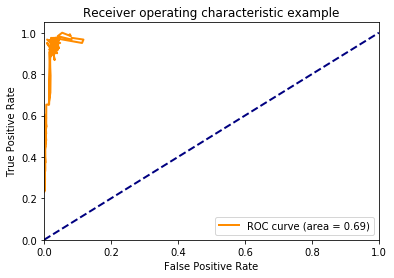

In [92]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [30]:
df = makeCorpusDataFrame("2018-02-04:2018-02-06",25,66)

0:01:08.981761


In [19]:
print(len(df.columns))

47316


In [21]:
print(len(columnsToKeep))

796


In [31]:
columnsToKeep=[]
for i in df.columns:
    if any(char.isdigit() for char in i):
        continue
    else:
        columnsToKeep.append(i)

In [69]:
trainingDF = df.loc[:,columnsToKeep]

In [11]:
def oversampling(df,ratio):
    posDF = pd.DataFrame(columns = df.columns)
    negDF = pd.DataFrame(columns = df.columns)
    posIndexes = []
    negIndexes = []
    testDF = df.reset_index()
    testDF.drop(labels='index',axis=1,inplace=True)
    for i in range(len(testDF)):
        if testDF.iloc[i,-1]== 1:
            posIndexes.append(i)
        else:
            negIndexes.append(i)
    numPositives = int(0.5*len(testDF))
    chosenIndexes =[]
    while len(chosenIndexes)<numPositives:
        index1 = np.random.randint(0,len(posIndexes))
        chosenIndexes.append(posIndexes[index1])
    numNegatives = len(testDF)-numPositives
    print(numNegatives)
    while len(chosenIndexes)<(numPositives+numNegatives):
        index1 =  np.random.randint(0,len(negIndexes))
        chosenIndexes.append(negIndexes[index1])
    trainingDF = testDF.loc[chosenIndexes,:]
    trainingDF.iloc[:,-1]=trainingDF.iloc[:,-1].astype('int')
    predDF = do_cv_class(trainingDF,10,'logreg')
    predDF['Prediction'] = predDF['Prediction'].astype(str).astype(int)
    predDF['Observed'] = predDF['Observed'].astype(str).astype(int)
    predDF['Accuracy'] = predDF.apply(lambda r: 1 if r['Observed']==r['Prediction'] else 0,axis=1)
    print(np.sum(predDF['Accuracy'])/float(len(predDF)))
    cf = confusion_matrix(predDF['Prediction'],predDF['Observed'],labels=[0,1])
    return (cf[0][0],cf[0][1],cf[1][0],cf[1][1])

In [ ]:
print(len(df[df['Label']==0]))

In [79]:
mainResults=[]

In [81]:
for i in np.arange(0.01,0.5,0.01):
    results = oversampling(trainingDF,0.5)
    mainResults.append(results)

21172
0.9761477423011524
21172
0.9768089930096354
21172
0.9778481012658228
21172
0.9738097487247308
21172
0.9759115813338372
21172
0.9758407330436425
21172
0.9756518042697903
21172
0.9764311354619308
21172
0.9784148875873796
21172
0.9773521632344606
21172
0.9770215378802192
21172
0.9767381447194408
21172
0.9772576988475344
21172
0.975769884753448
21172
0.9766436803325147
21172
0.9761477423011524
21172
0.9749669374645759
21172
0.9771160022671452
21172
0.9774230115246552
21172
0.9765019837521255
21172
0.9760060457207633
21172
0.9763366710750048
21172
0.9773049310409976
21172
0.975061401851502
21172
0.9750141696580389
21172
0.9760768940109579
21172
0.9737861326279993
21172
0.975769884753448
21172
0.9756990364632534
21172
0.976927073493293
21172
0.9770451539769507
21172
0.9770451539769507
21172
0.9774230115246552
21172
0.9756518042697903
21172
0.9766672964292462
21172
0.9772340827508029
21172
0.9746126960136029
21172
0.9762658227848101
21172
0.9768326091063669
21172
0.9764311354619308
2117

In [96]:
fpr=[]
tpr=[]
for i in range(len(mainResults)):
    try:
        tp = mainResults[i][3]
        fp = mainResults[i][2]
        tn = mainResults[i][0]
        fn = mainResults[i][1]
        tprScalar = float(tp)/(tp+fn)
        fprScalar = float(fp)/(fp+tn)
        fpr.append(fprScalar)
        tpr.append(tprScalar)
    except Exception as e:
#         print(e)
        continue

In [14]:
tp = results[3]
fp = results[2]
tn = results[0]
fn = results[1]
tprScalar = float(tp)/(tp+fn)
fprScalar = float(fp)/(fp+tn)

In [15]:
tprScalar

0.18181818181818182

In [16]:
fprScalar

0.0003315728394476944

In [13]:
trainingDF = makeCorpusDataFrame("2018-02-04:2018-02-06",25,66)
columnsToKeep=[]
for i in trainingDF.columns:
    if any(char.isdigit() for char in i):
        continue
    else:
        columnsToKeep.append(i)
trainingDF = trainingDF.loc[:,columnsToKeep]

0:01:14.451841


In [14]:
posIndexes = list(np.where(trainingDF['Label']==1)[0])
posIndexesworeplacement = posIndexes.copy()

In [15]:
negIndexes = list(np.where(trainingDF['Label']==0)[0])
negIndexesworeplacement = negIndexes.copy()

In [16]:
allSamples = len(trainingDF)

In [22]:
posSamples = len(posIndexes)

In [55]:
ratio = len(posIndexes)/len(negIndexes)
print(ratio)

0.00286573668379793


In [56]:
ratio = 0.005
posSamples = ratio*allSamples
negSamples = allSamples - posSamples
print(negSamples)

42132.28


In [60]:
negIndexesPicked = []
while len(negIndexesPicked)<negSamples:
    if len(negIndexesworeplacement)>0:
        indexPicked = random.choice(negIndexesworeplacement)
        negIndexesPicked.append(indexPicked)
        negIndexesworeplacement.remove(indexPicked) 
    else:
        negIndexesworeplacement = negIndexes.copy()

In [62]:
posIndexesPicked = []
while len(posIndexesPicked)<posSamples:
    if len(posIndexesworeplacement)>0:
        indexPicked = random.choice(posIndexesworeplacement)
        posIndexesPicked.append(indexPicked)
        posIndexesworeplacement.remove(indexPicked) 
    else:
        posIndexesworeplacement = posIndexes.copy()

In [80]:
print(len((posIndexesPicked)))

212


In [72]:
ratioDF = trainingDF.loc[trainingDF.index[posIndexesPicked+negIndexesPicked],:]

In [73]:
predDF = do_cv_class(ratioDF,10,'logreg')
predDF['Prediction'] = predDF['Prediction'].astype(str).astype(int)
predDF['Observed'] = predDF['Observed'].astype(str).astype(int)
predDF['Accuracy'] = predDF.apply(lambda r: 1 if r['Observed']==r['Prediction'] else 0,axis=1)
print(np.sum(predDF['Accuracy'])/float(len(predDF)))
cf = confusion_matrix(predDF['Prediction'],predDF['Observed'],labels=[0,1])

0.9959381272877553


In [75]:
results = (cf[0][0],cf[0][1],cf[1][0],cf[1][1])

In [76]:
tp = results[3]
fp = results[2]
tn = results[0]
fn = results[1]
tprScalar = float(tp)/(tp+fn)
fprScalar = float(fp)/(fp+tn)

In [77]:
tprScalar

0.27358490566037735

In [78]:
fprScalar

0.0004272185697671659

In [20]:
def makeROC(ratio,posSamples):
    negSamples = ratio*posSamples
#     posIndexesworeplacement = posIndexes.copy()
    negIndexesworeplacement = negIndexes.copy()
    negIndexesPicked = []
    while len(negIndexesPicked)<negSamples:
        if len(negIndexesworeplacement)>0:
            indexPicked = random.choice(negIndexesworeplacement)
            negIndexesPicked.append(indexPicked)
            negIndexesworeplacement.remove(indexPicked) 
        else:
            negIndexesworeplacement = negIndexes.copy()
#     posIndexesPicked = []
#     while len(posIndexesPicked)<posSamples:
#         if len(posIndexesworeplacement)>0:
#             indexPicked = random.choice(posIndexesworeplacement)
#             posIndexesPicked.append(indexPicked)
#             posIndexesworeplacement.remove(indexPicked) 
#         else:
#             posIndexesworeplacement = posIndexes.copy()
    posIndexesPicked = posIndexes.copy()
    ratioDF = trainingDF.loc[trainingDF.index[posIndexesPicked+negIndexesPicked],:]
    predDF = do_cv_class(ratioDF,10,'logreg')
    predDF['Prediction'] = predDF['Prediction'].astype(str).astype(int)
    predDF['Observed'] = predDF['Observed'].astype(str).astype(int)
    predDF['Accuracy'] = predDF.apply(lambda r: 1 if r['Observed']==r['Prediction'] else 0,axis=1)
    print(np.sum(predDF['Accuracy'])/float(len(predDF)))
    cf = confusion_matrix(predDF['Prediction'],predDF['Observed'],labels=[0,1])
    results = (cf[0][0],cf[0][1],cf[1][0],cf[1][1])
    tp = results[3]
    fp = results[2]
    tn = results[0]
    fn = results[1]
    tprScalar = float(tp)/(tp+fn)
    fprScalar = float(fp)/(fp+tn)
    return (tprScalar,fprScalar)

In [84]:
answerResults = []
for i in np.arange(0.01,0.5,0.01):
    answerResults.append(makeROC(i,posSamples=posSamples))

0.991869918699187
0.9758064516129032
0.976
0.9920634920634921
0.96875
0.9844961240310077
0.9846153846153847
0.9847328244274809
0.9772727272727273
0.9552238805970149
0.9851851851851852
0.9558823529411765
0.9635036496350365
0.9782608695652174
0.9714285714285714
0.9716312056737588
0.9859154929577465
0.993006993006993
0.9861111111111112
0.9657534246575342
0.9591836734693877
0.9527027027027027
0.9731543624161074
0.9602649006622517
0.9671052631578947
0.9738562091503268
0.9545454545454546
0.9741935483870968
0.9490445859872612
0.9683544303797469
0.9622641509433962
0.98125
0.9627329192546584
0.9754601226993865
0.9634146341463414
0.9454545454545454
0.963855421686747
0.9640718562874252
0.9585798816568047
0.9411764705882353
0.9590643274853801
0.9476744186046512
0.9885057471264368
0.9771428571428571
0.9545454545454546
0.9548022598870056
0.9382022471910112
0.9833333333333333
0.9613259668508287


In [85]:
answerResults

[(0.9917355371900827, 0.0),
 (0.9917355371900827, 0.6666666666666666),
 (0.9917355371900827, 0.5),
 (0.9917355371900827, 0.0),
 (0.9834710743801653, 0.2857142857142857),
 (0.9917355371900827, 0.125),
 (1.0, 0.2222222222222222),
 (0.9917355371900827, 0.1),
 (0.9834710743801653, 0.09090909090909091),
 (0.9752066115702479, 0.23076923076923078),
 (0.9917355371900827, 0.07142857142857142),
 (0.9834710743801653, 0.26666666666666666),
 (0.9752066115702479, 0.125),
 (0.9917355371900827, 0.11764705882352941),
 (0.9752066115702479, 0.05263157894736842),
 (0.9917355371900827, 0.15),
 (0.9917355371900827, 0.047619047619047616),
 (1.0, 0.045454545454545456),
 (0.9917355371900827, 0.043478260869565216),
 (0.9669421487603306, 0.04),
 (0.9752066115702479, 0.11538461538461539),
 (0.9752066115702479, 0.14814814814814814),
 (0.9834710743801653, 0.07142857142857142),
 (0.9752066115702479, 0.1),
 (0.9752066115702479, 0.06451612903225806),
 (0.9917355371900827, 0.09375),
 (0.9669421487603306, 0.090909090909